## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

1. Загрузка и ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Загрузка данных
data = pd.read_csv('ab_test_ensembles.csv')

# Общая информация о данных
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB
None
           converted
count  294478.000000
mean        0.119659
std         0.324563
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
                                user_id                   timestamp  \
0  9109b0dc-d393-497f-8d63-ba9a25dd16b4  2022-05-21 22:11:48.556739   
1  2430c3d2-f75b-4b31-8271-51b6a76c2652  2022-05-12 08:01:45.159739   
2  44788c4e-8dd2-4fad-b986-75e76

Выводы:
- Данные содержат следующие столбцы: user_id, timestamp, group, converted, user_type.
- Нет пропущенных значений.

2. Предварительный анализ данных (EDA)

2.1. Проверка распределения групп и типов пользователей

In [2]:
# Распределение по группам
group_counts = data['group'].value_counts()
print(group_counts)

# Распределение по типам пользователей
user_type_counts = data['user_type'].value_counts()
print(user_type_counts)

# Распределение конверсии по группам
conversion_rates = data.groupby('group')['converted'].mean()
print(conversion_rates)

# Распределение конверсии по типам пользователей
conversion_rates_user_type = data.groupby('user_type')['converted'].mean()
print(conversion_rates_user_type)


group
treatment    147276
control      147202
Name: count, dtype: int64
user_type
registered_user    147240
new_user           147238
Name: count, dtype: int64
group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64
user_type
new_user           0.119154
registered_user    0.120164
Name: converted, dtype: float64


Выводы:
-Группы распределены примерно равномерно.
-Типы пользователей (новые и зарегистрированные) также распределены равномерно.
-Разница в конверсии между группами и типами пользователей незначительная на первый взгляд.
2.2. Визуализация данных
График 1: Распределение конверсии по группам

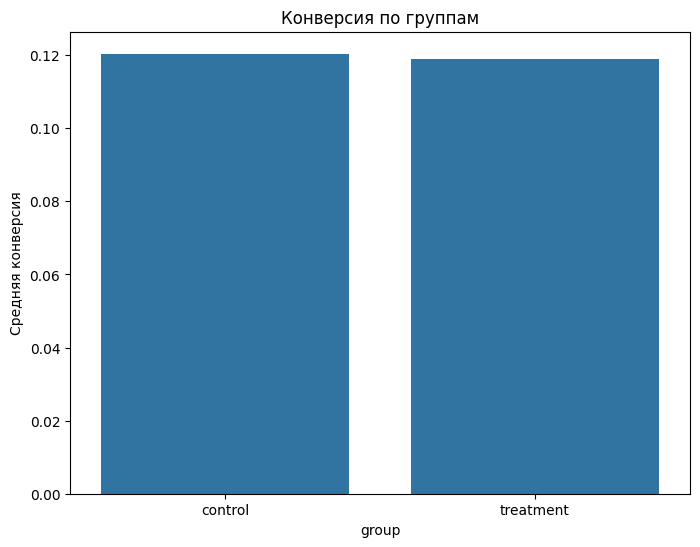

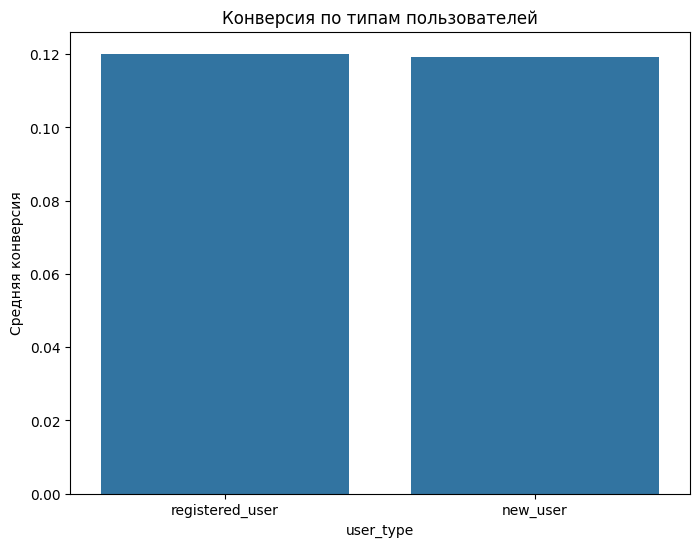

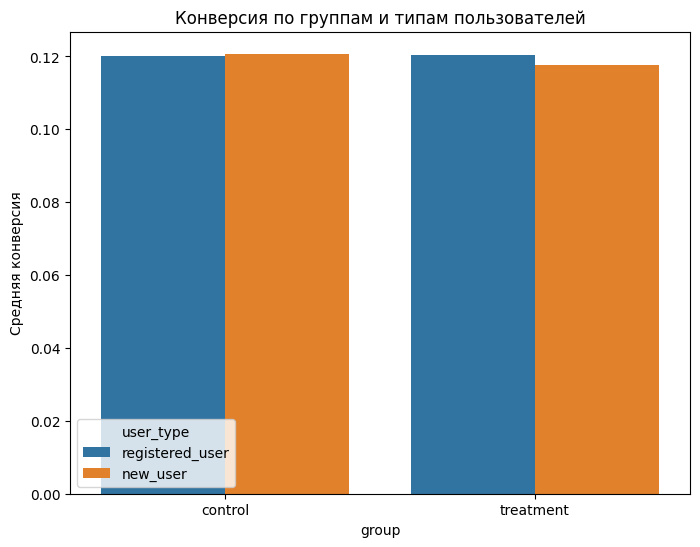

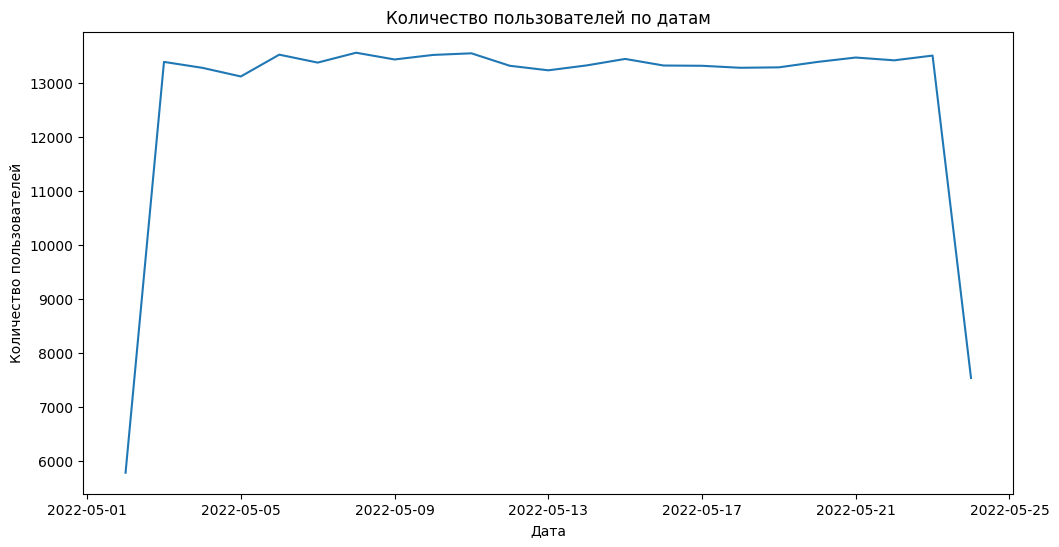

In [3]:
#График 1: Распределение конверсии по группам
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='converted', data=data, errorbar=('ci', False))
plt.title('Конверсия по группам')
plt.ylabel('Средняя конверсия')
plt.show()
#График 2: Распределение конверсии по типам пользователей
plt.figure(figsize=(8, 6))
sns.barplot(x='user_type', y='converted', data=data, errorbar=('ci', False))
plt.title('Конверсия по типам пользователей')
plt.ylabel('Средняя конверсия')
plt.show()
#График 3: Распределение конверсии по группам и типам пользователей
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='converted', hue='user_type', data=data, errorbar=('ci', False))
plt.title('Конверсия по группам и типам пользователей')
plt.ylabel('Средняя конверсия')
plt.show()
#График 4: Распределение количества пользователей по времени
# Преобразование столбца timestamp в формат datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['date'] = data['timestamp'].dt.date

# Построение графика
plt.figure(figsize=(12, 6))
data.groupby('date').size().plot()
plt.title('Количество пользователей по датам')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.show()

Выводы по графикам:
-Конверсия по группам очень близка.
-Конверсия по типам пользователей также близка.
-Распределение конверсии по группам и типам пользователей не показывает явных различий.
-Количество пользователей по датам относительно стабильное.
3. Статистический анализ
3.1. Тестирование гипотезы для всей выборки
Гипотезы:
-Нулевая гипотеза (H0): Разница в конверсии между группами отсутствует.
-Альтернативная гипотеза (H1): Разница в конверсии между группами существует.
Проведем Z-тест для пропорций:

In [4]:
# Данные для теста
convert_control = data[data['group'] == 'control']['converted'].sum()
convert_treatment = data[data['group'] == 'treatment']['converted'].sum()
n_control = data[data['group'] == 'control']['converted'].count()
n_treatment = data[data['group'] == 'treatment']['converted'].count()

# Статистика и p-value
stat, p_value = proportions_ztest([convert_treatment, convert_control], [n_treatment, n_control])

# Доверительные интервалы
(confint_treatment_low, confint_control_low), (confint_treatment_high, confint_control_high) = proportion_confint(
    [convert_treatment, convert_control], [n_treatment, n_control], alpha=0.05)

print(f"Z-статистика: {stat:.4f}")
print(f"P-значение: {p_value:.4f}")
print(f"Доверительный интервал для контрольной группы: [{confint_control_low:.4f}, {confint_control_high:.4f}]")
print(f"Доверительный интервал для тестовой группы: [{confint_treatment_low:.4f}, {confint_treatment_high:.4f}]")


Z-статистика: -1.2369
P-значение: 0.2161
Доверительный интервал для контрольной группы: [0.1187, 0.1221]
Доверительный интервал для тестовой группы: [0.1173, 0.1206]


Вывод:
- P-значение (0.2161) больше уровня значимости 0.05, поэтому мы не можем отвергнуть нулевую гипотезу.
- Статистически значимой разницы между группами нет.
- Рекомендуется оставить старый вариант работы сервиса.
- 
3.2. Тестирование гипотезы для новых пользователей
Гипотезы:
- Нулевая гипотеза (H0): Разница в конверсии между группами для новых пользователей отсутствует.
- Альтернативная гипотеза (H1): Разница в конверсии между группами для новых пользователей существует.
- 
Проведем Z-тест для новых пользователей:

In [5]:
# Фильтрация данных для новых пользователей
new_users = data[data['user_type'] == 'new_user']

# Данные для теста
convert_control_new = new_users[new_users['group'] == 'control']['converted'].sum()
convert_treatment_new = new_users[new_users['group'] == 'treatment']['converted'].sum()
n_control_new = new_users[new_users['group'] == 'control']['converted'].count()
n_treatment_new = new_users[new_users['group'] == 'treatment']['converted'].count()

# Статистика и p-value
stat_new, p_value_new = proportions_ztest([convert_treatment_new, convert_control_new], [n_treatment_new, n_control_new])

print(f"Новые пользователи - Z-статистика: {stat_new:.4f}")
print(f"Новые пользователи - P-значение: {p_value_new:.4f}")

Новые пользователи - Z-статистика: -1.8886
Новые пользователи - P-значение: 0.0589


Вывод:
- P-значение (0.0589) немного выше 0.05, но очень близко к уровню значимости.
- Это указывает на тенденцию к статистически значимой разнице между группами для новых пользователей.
- Возможно, стоит провести дополнительный анализ или рассмотреть более высокий уровень значимости (например, 10%).
- 
3.3. Тестирование гипотезы для зарегистрированных пользователей

In [6]:
# Фильтрация данных для зарегистрированных пользователей
registered_users = data[data['user_type'] == 'registered_user']

# Данные для теста
convert_control_reg = registered_users[registered_users['group'] == 'control']['converted'].sum()
convert_treatment_reg = registered_users[registered_users['group'] == 'treatment']['converted'].sum()
n_control_reg = registered_users[registered_users['group'] == 'control']['converted'].count()
n_treatment_reg = registered_users[registered_users['group'] == 'treatment']['converted'].count()

# Статистика и p-value
stat_reg, p_value_reg = proportions_ztest([convert_treatment_reg, convert_control_reg], [n_treatment_reg, n_control_reg])

print(f"Зарегистрированные пользователи - Z-статистика: {stat_reg:.4f}")
print(f"Зарегистрированные пользователи - P-значение: {p_value_reg:.4f}")


Зарегистрированные пользователи - Z-статистика: 0.1332
Зарегистрированные пользователи - P-значение: 0.8940


Вывод:
- Для зарегистрированных пользователей P-значение значительно больше 0.05.
- Нет статистически значимой разницы между группами для зарегистрированных пользователей.

4. Дополнительный анализ
4.1. Анализ конверсии по датам

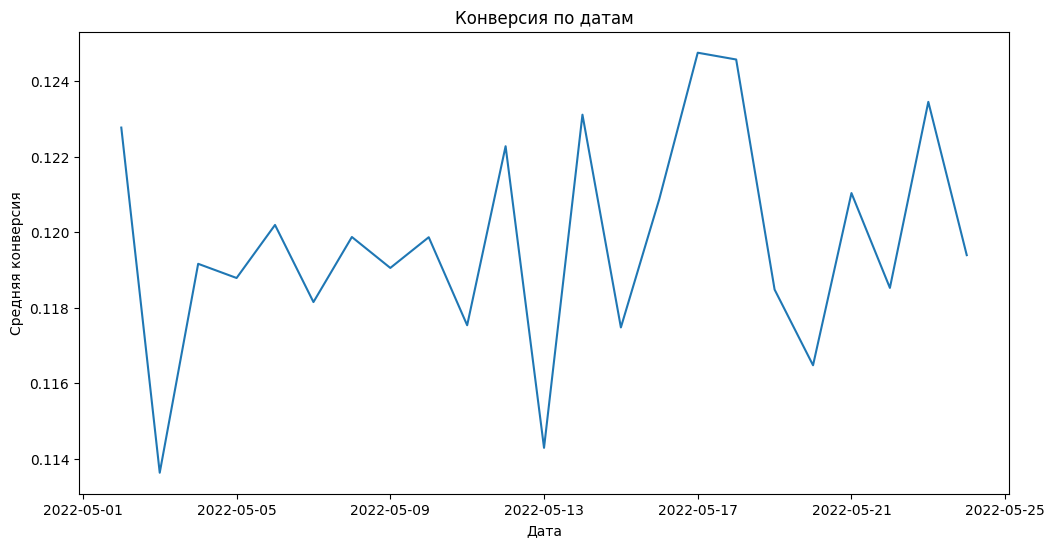

In [7]:
#График 5 Конверсия по датам
daily_conversion = data.groupby('date')['converted'].mean()

plt.figure(figsize=(12, 6))
daily_conversion.plot()
plt.title('Конверсия по датам')
plt.ylabel('Средняя конверсия')
plt.xlabel('Дата')
plt.show()


Вывод:
- Конверсия по датам стабильна, нет резких всплесков или падений.
4.2. Анализ взаимодействия групп и типов пользователей

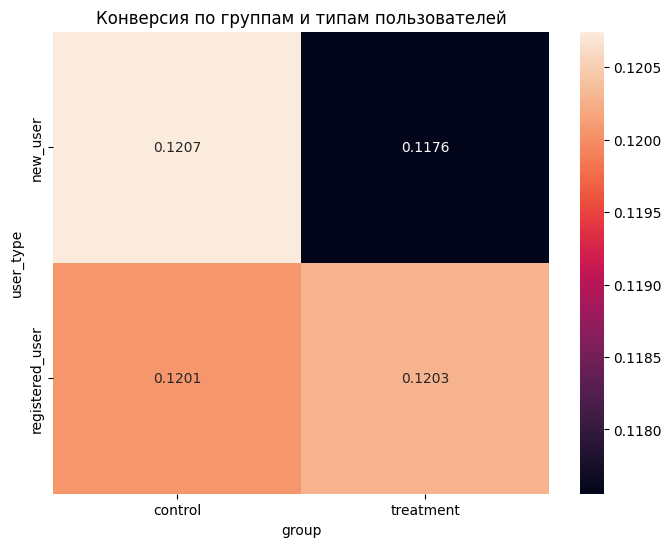

In [8]:
pivot_table = data.pivot_table(values='converted', index='user_type', columns='group', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Конверсия по группам и типам пользователей')
plt.show()


Вывод:
- Для новых пользователей:
    - Конверсия в группе treatment ниже (11.76%), чем в группе control (12.07%).
    - Это может объяснять низкое P-значение (0.0589) в тесте для новых пользователей.
- Для зарегистрированных пользователей:
    - Конверсия в группах практически идентична (~12.0%).
    - Нет значимых отличий между группами.

5. Общие выводы
Ответ на вопрос 1: 
- Статистически значимой разницы между старым вариантом и svm_ensemble_v_1_22 нет.
- Рекомендуется оставить старый вариант работы сервиса.
Ответ на вопрос 2:
- Для новых пользователей P-значение (0.0589) близко к уровню значимости 0.05.
- Это указывает на возможную негативную тенденцию при использовании варианта svm_ensemble_v_1_22 для новых пользователей.
- Рекомендуется оставить старый вариант работы для новых пользователей.
- Для зарегистрированных пользователей нет статистически значимой разницы; однако, учитывая общее отсутствие положительного эффекта, 
целесообразно оставить старый вариант для всех пользователей.

Заключение

Проведенный анализ показал, что внедрение варианта svm_ensemble_v_1_22 не приводит к улучшению конверсии и даже может негативно влиять 
на новых пользователей. В связи с этим рекомендуется оставить текущий вариант работы сервиса для всех пользователей и провести дополнительный анализ
для выявления и устранения возможных проблем.